<a href="https://colab.research.google.com/github/snowshine/NFTCreators/blob/main/gan/process_image.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# !pip install Image

Mount google drive to colab. need run for every session

In [4]:
from google.colab import drive
drive.mount('/content/drive')
# drive._mount('/content/drive')
# drive.mount("/content/drive", force_remount=True)

# change working directory
%cd /content/drive/Shareddrives/Capstone/
!ls -art

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/Shareddrives/Capstone
cryptopunks.zip		   crytopunks_image_data      cryptopunks.npz
mutant-ape-yacht-club.zip  mutant_image_data	      cryptopunks32.npz
mutant-ape-yacht-club	   cryptopunks32_0.npz
cryptopunks		   mutant-ape-yacht-club.npz


### Preparing the image dataset: convert to NumPy arrays and store for later use

load and preprocess the images. store the processed file as a binary. This way we can simply reload the processed training data and quickly use it. 

In [5]:
import numpy as np
from PIL import Image
from tqdm import tqdm
import os 
import time
import matplotlib.pyplot as plt

def hms_string(sec_elapsed):
    h = int(sec_elapsed / (60 * 60))
    m = int((sec_elapsed % (60 * 60)) / 60)
    s = sec_elapsed % 60.
    return "{}:{:>02}:{:>05.2f}".format(h, m, s)

def prepareImages(dir, name, imgshape):
  start = time.time()

  training_data = []  
  imgfiles   = np.sort(os.listdir(dir))
  for filename in tqdm(imgfiles):      
      path = os.path.join(dir,filename)
      image = Image.open(path).resize(imgshape, Image.ANTIALIAS).convert('RGB')      
      training_data.append(np.asarray(image)/255)
  
  # training_data = np.reshape(training_data,(-1,GENERATE_SQUARE,GENERATE_SQUARE,IMAGE_CHANNELS))
  # training_data = training_data.astype(np.float32)
  # training_data = training_data / 127.5 - 1.

  # Saving training image binary
  savedfile = name + ".npz"  # size much smaller than .npy
  np.savez_compressed(savedfile, training_data)
  
  print (f'Image preprocess time: {hms_string(time.time()-start)}')

  return savedfile

In [63]:
# img_shape = (128, 128, 3)
# prepareImages('cryptopunks', 'cryptopunks', (32,32))
prepareImages('cryptopunks', 'cryptopunks', (128,128))
prepareImages('mutant-ape-yacht-club', 'mutant-ape-yacht-club', (128,128))  # 0:06:42.82


100%|██████████| 10000/10000 [00:31<00:00, 314.19it/s]


Image preprocess time: 0:00:33.49


'cryptopunks.npz'

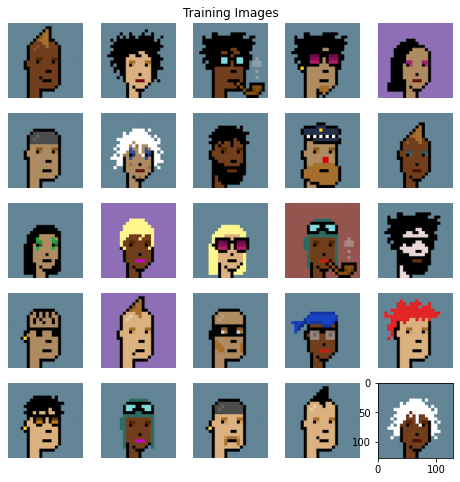

In [6]:
image_data = np.load('cryptopunks.npz')['arr_0'][:50]

import matplotlib.pyplot as plt
def plot_images(imgs, grid_size = 5):
    """
    plot images in a nxn grid
    imgs: vector containing all the numpy images
    grid_size: nxn grid containing images
    """     
    fig = plt.figure(figsize = (8, 8))
    columns = rows = grid_size
    plt.title("Training Images")
 
    for i in range(1, columns*rows+1):
        plt.axis("off")
        fig.add_subplot(rows, columns, i)
        plt.imshow(imgs[i])
    plt.show()

plot_images(image_data)